# Лабораторная работа 5 — Классификация (Вариант 3)

Набор данных: `ecommerce_fraud.csv` (вариант 3).

**Цель:** изучение алгоритмов и методов классификации на практике.

1. Загрузка набора данных и импорт библиотек

Также на экран были выведены размер датасета, первые 5 строк и информация о столбцах, которая показывает, что в данных нет пропусков и все типы данных соответствуют реальным данным

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, balanced_accuracy_score, confusion_matrix, 
                             roc_curve, roc_auc_score, )

# Настройка стиля графиков
sns.set_theme(style="whitegrid")

# Загрузка данных
df = pd.read_csv('ecommerce_fraud.csv')

# Обзор данных
print("Размер датасета:", df.shape)
display(df.head())
print("Информация о типах данных:")
display(df.info())

Размер датасета: (3024, 12)


,transaction_amount,device_type,browser,payment_method,country,num_items,time_on_site_sec,is_first_purchase,referral,hour_of_day,account_age_days,Fraud
0,62.18,Desktop,Safari,COD,UK,3,58.0,No,Direct,15,808,0
1,28.16,Desktop,Chrome,COD,US,2,75.0,Yes,Direct,10,753,0
2,17.57,Mobile,Chrome,Card,DE,1,101.0,No,Social,21,1017,0
3,61.61,Desktop,Safari,PayPal,Other,4,63.0,Yes,Search,20,1146,0
4,4.28,Desktop,Edge,Card,BR,7,399.0,No,Direct,4,1134,0


Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3024 entries, 0 to 3023
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   transaction_amount  3024 non-null   float64
 1   device_type         3024 non-null   object 
 2   browser             3024 non-null   object 
 3   payment_method      3024 non-null   object 
 4   country             3024 non-null   object 
 5   num_items           3024 non-null   int64  
 6   time_on_site_sec    3024 non-null   float64
 7   is_first_purchase   3024 non-null   object 
 8   referral            3024 non-null   object 
 9   hour_of_day         3024 non-null   int64  
 10  account_age_days    3024 non-null   int64  
 11  Fraud               3024 non-null   int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 283.6+ KB


None

Данные содержат 3024 записи о мошеннических транзакциях:

- **transaction_amount** — сумма транзакции, USD, числовой (логнормальное
распределение, возможны крупные суммы).

- **device_type** — тип устройства: *Desktop / Mobile / Tablet*, категориальный.

- **browser** — браузер: *Chrome / Safari / Firefox / Edge / Other*, категориальный.

- **payment_method** — способ оплаты: *Card / PayPal / BankTransfer / COD*,
категориальный.

- **country** — страна покупателя: *US / UK / DE / FR / IN / BR / CN / Other*,
категориальный.

- **num_items** — количество товаров в заказе, целочисленный (1–7).

- **time_on_site_sec** — время на сайте до покупки, секунды, числовой.

- **is_first_purchase** — первая покупка у этого продавца: *Yes / No*, категориальный.

- **referral** — источник трафика: *Direct / Search / Social / Ads*, категориальный.

- **hour_of_day** — час суток оформления заказа (0–23), целочисленный.

- **account_age_days** — «возраст» аккаунта, в днях, числовой.

- **Fraud** — целевой класс: 1 — мошенническая транзакция, 0 — нормальная


2. Предобработка данных

Первичный анализ данных, позволяющий понять структуру набора: количество признаков и наблюдений, типы данных и возможные проблемы. Такой анализ необходим, чтобы убедиться в корректности данных и определить необходимость последующей предобработки — масштабирования, очистки или удаления выбросов.

In [40]:
print(df.describe)

categorical_columns = [
    'device_type', 'browser', 'payment_method', 'country',
    'is_first_purchase', 'referral'
]

for col in categorical_columns:
    print(f"\nРаспределение значений в '{col}':")
    display(df[col].value_counts())

<bound method NDFrame.describe of       transaction_amount device_type  browser payment_method country  \
0                 62.180     Desktop   Safari            COD      UK   
1                 28.160     Desktop   Chrome            COD      US   
2                 17.570      Mobile   Chrome           Card      DE   
3                 61.610     Desktop   Safari         PayPal   Other   
4                  4.280     Desktop     Edge           Card      BR   
...                  ...         ...      ...            ...     ...   
3019            1325.200     Desktop     Edge           Card      US   
3020             330.050      Mobile   Safari           Card      UK   
3021             321.625     Desktop   Chrome           Card      US   
3022             342.750     Desktop  Firefox           Card      US   
3023             271.175     Desktop   Safari           Card      UK   

      num_items  time_on_site_sec is_first_purchase referral  hour_of_day  \
0             3         

device_type
Mobile     1439
Desktop    1363
Tablet      222
Name: count, dtype: int64


Распределение значений в 'browser':


browser
Chrome     1491
Safari      606
Firefox     462
Edge        324
Other       141
Name: count, dtype: int64


Распределение значений в 'payment_method':


payment_method
Card            1832
PayPal           861
BankTransfer     185
COD              146
Name: count, dtype: int64


Распределение значений в 'country':


country
US       984
IN       350
UK       328
Other    305
BR       294
CN       278
DE       243
FR       242
Name: count, dtype: int64


Распределение значений в 'is_first_purchase':


is_first_purchase
No     1778
Yes    1246
Name: count, dtype: int64


Распределение значений в 'referral':


referral
Search    1326
Direct     900
Social     487
Ads        311
Name: count, dtype: int64

3. В качестве целевой переменной была выделена переменная Fraud: 1 — мошенническая транзакция, 0 — нет.

Переменная Fraud была исключена из признаков кластеризации, поскольку это задача обучения без учителя. Она будет использована далее для интерпретации кластеров по уровню риска. Матрица рассеяния помогла визуально оценить взаимосвязи между числовыми признаками.

<Figure size 1000x1000 with 0 Axes>

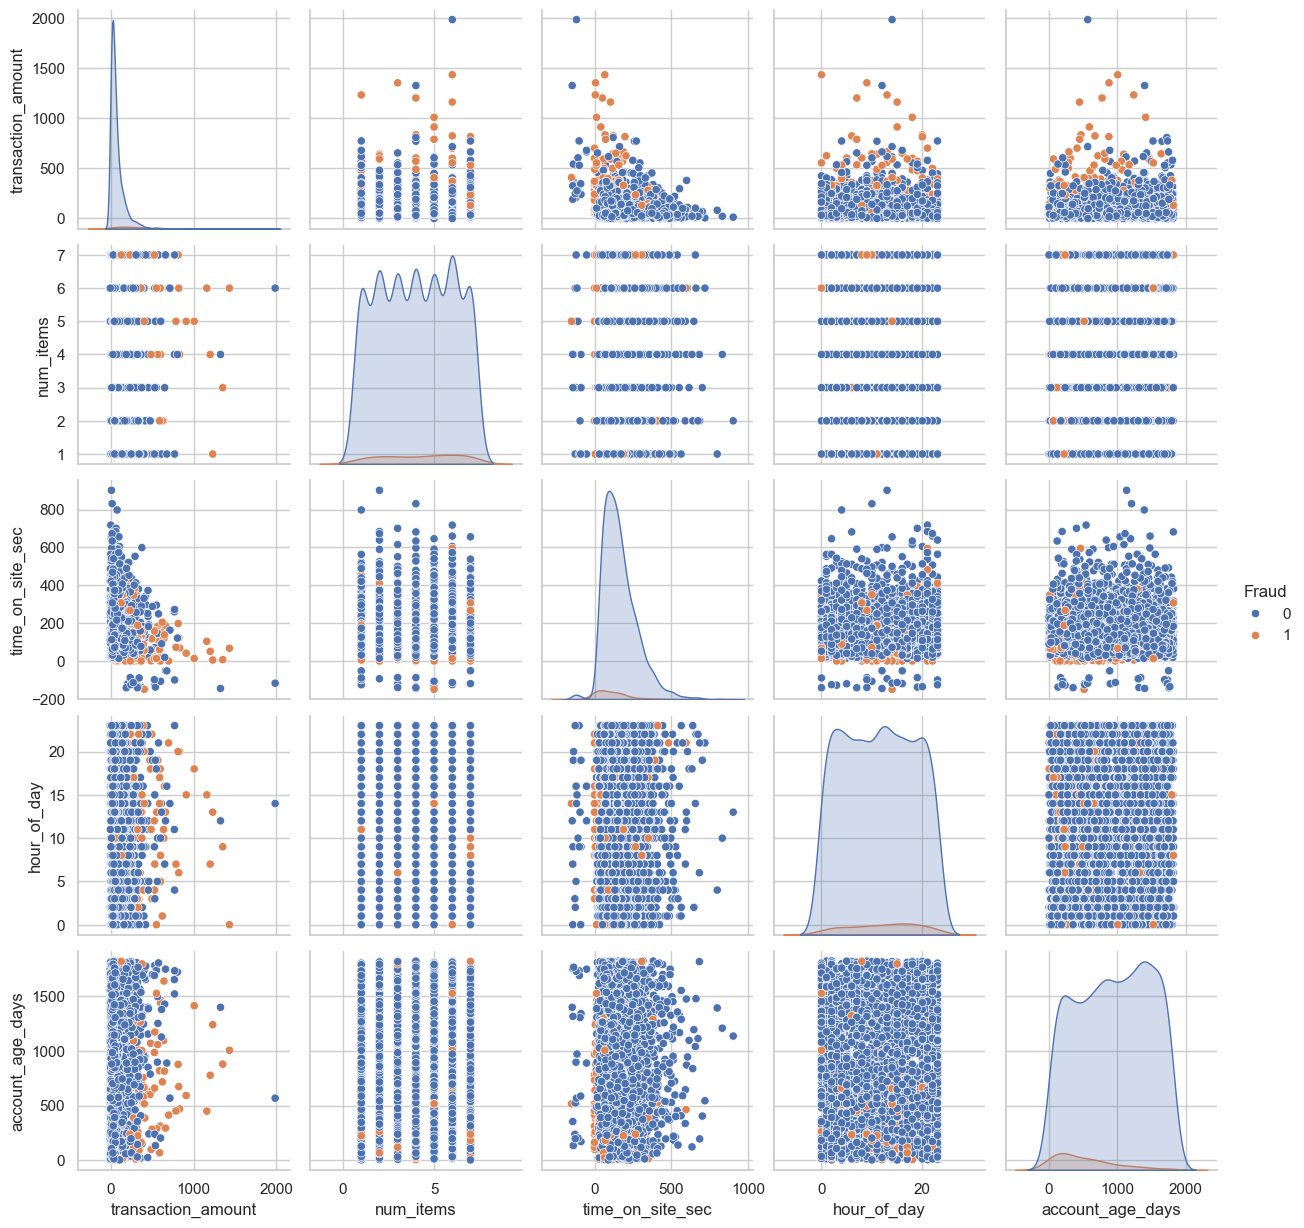

In [27]:
# Предобработка
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

# Целевая переменная — Fraud (исключаем из признаков)
target_col = "Fraud"
y = df[target_col].copy()
X = df.drop(columns=[target_col]).copy()
# Выделение числовых признаков
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()


# Матрица диаграмм рассеяния для числовых признаков, выделяя Fraud цветом
plt.figure(figsize=(10,10))
sns.pairplot(df, vars=num_cols, hue='Fraud')
plt.show()


По полученным диаграммам можно сделать следующие выводы:

- **Мошенничество не сильно зависит от количества товаров в корзине (`num_items`).** На графике `num_items` видно, что распределение мошеннических транзакций (зелёные точки) практически совпадает с легитимными (синие) по всем категориям от 1 до 7 товаров. Это говорит о том, что количество товаров не является сильным предиктором фрода.

- **Мошенничество чаще происходит при очень малом времени на сайте (`time_on_site_sec`).** На графике `time_on_site_sec` заметно, что многие зелёные точки (фрод) находятся в левой части — при времени на сайте близком к нулю или очень малом (менее 50 секунд). Это может указывать на автоматизированные атаки или спешку мошенника, который не тратит время на изучение сайта.

- **Нет явной зависимости от времени суток (`hour_of_day`).** Распределение мошеннических транзакций по часам суток выглядит примерно таким же, как и легитимных. Никаких резких пиков в определённое время (например, ночью или утром) не наблюдается. Это говорит о том, что мошенники работают круглосуточно, без чёткой временной привязки.

- **Мошенничество чаще происходит на аккаунтах с малым возрастом (`account_age_days`).** На графике `account_age_days` видно, что зелёные точки (фрод) концентрируются слева — то есть на аккаунтах, которым меньше года (особенно менее 200 дней). Это типичная картина: мошенники часто используют новые аккаунты, чтобы обойти системы безопасности, связанные с репутацией пользователя.


4. Разбиение набора данных на тренировочной и тестовый датасеты с помощью train_test_split и
выполнение стандартизации числовых данных.

Затем набор данных был разделен на тренировочный и тестовый датасеты с помощью train_test_split, также была выполнена стандартизация числовых данных. Было применено One-Hot Encoding для категориальных признаков и StandardScaler для числовых признаков.
Данные разделены на train и test выборки (75/25).
Так как KNN и логистическая регрессия требуют масштабирования, деревья и случайный лес - нет. Поэтому:

X_train_scaled, X_test_scaled - для KNN и LogReg

X_train, X_test - для DecisionTree и RandomForest

In [28]:
# Загрузка данных
df = pd.read_csv('ecommerce_fraud.csv')

# Целевая переменная
y = df['Fraud']

# Признаки (исключаем целевой столбец)
X = df.drop(columns=['Fraud'])

# Определение категориальных и числовых колонок
cat_cols = ['device_type', 'browser', 'payment_method', 'country', 'is_first_purchase', 'referral']
num_cols = ['transaction_amount', 'num_items', 'time_on_site_sec', 'hour_of_day', 'account_age_days']

# One-Hot Encoding для категориальных признаков
X_encoded = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# Обновление списка числовых колонок (после кодирования они не меняются, но для чистоты)
num_cols_encoded = [col for col in num_cols if col in X_encoded.columns]

# Разделение на train/test выборки (75/25 → test_size=0.25), с сохранением пропорций классов
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

# Стандартизация числовых признаков
scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols_encoded] = scaler.fit_transform(X_train[num_cols_encoded])
X_test_scaled[num_cols_encoded] = scaler.transform(X_test[num_cols_encoded])

print("Размеры выборок:")
print(f"Train: {X_train.shape}, Test: {X_test.shape}")

Размеры выборок:
Train: (2268, 25), Test: (756, 25)


5. Разработка предсказательной модели качественного отклика методами:
метод k- ближайших соседей, дерево решений, логистическая регрессия, случайный лес с помощью соответсвующих функций: KNeighborsClassifier, DecisionTreeClassifier, LogisticRegression, RandomForestClassifier


In [29]:
# Обучение и предсказание методом KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
y_pred_knn = knn.predict(X_test_scaled)

# Обучение и предсказание методом дерева решений
dt = DecisionTreeClassifier(random_state=42, max_depth=5)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Обучение и предсказание методом логистической регрессии
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)

# Обучение и предсказание методом случайного леса
rf = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=5)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

6. Оценка ошибки классификации для каждого метода. Подсчет метрик "Accuracy",
"Precision", "Recall", "Balanced accuracy", 'F1 score'.

In [30]:
# Метрики методом KNN
print("KNN")
print("Accuracy:", accuracy_score(y_test, y_pred_knn))
print("Precision:", precision_score(y_test, y_pred_knn))
print("Recall:", recall_score(y_test, y_pred_knn))
print("F1-score:", f1_score(y_test, y_pred_knn))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_knn))

KNN
Accuracy: 0.9576719576719577
Precision: 0.5714285714285714
Recall: 0.23529411764705882
F1-score: 0.3333333333333333
Balanced Accuracy: 0.6134919341697898


In [31]:
# Метрики методом дерева решений
print("Decision Tree")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("Precision:", precision_score(y_test, y_pred_dt))
print("Recall:", recall_score(y_test, y_pred_dt))
print("F1-score:", f1_score(y_test, y_pred_dt))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_dt))

Decision Tree
Accuracy: 0.9682539682539683
Precision: 0.9166666666666666
Recall: 0.3235294117647059
F1-score: 0.4782608695652174
Balanced Accuracy: 0.6610721851067297


In [32]:
# Метрики методом логистической регресии
print("Logistic Regression")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-score:", f1_score(y_test, y_pred_lr))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_lr))

Logistic Regression
Accuracy: 0.9629629629629629
Precision: 0.8
Recall: 0.23529411764705882
F1-score: 0.36363636363636365
Balanced Accuracy: 0.6162620172722829


In [33]:
# Метрики методом случайного леса
print("Random Forest")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf))
print("Recall:", recall_score(y_test, y_pred_rf))
print("F1-score:", f1_score(y_test, y_pred_rf))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_rf))

Random Forest
Accuracy: 0.9603174603174603
Precision: 1.0
Recall: 0.11764705882352941
F1-score: 0.21052631578947367
Balanced Accuracy: 0.5588235294117647


### 1. Общая картина: 
Все модели показывают высокую общую точность (Accuracy) — от 82.8% до 86.6%, что на первый взгляд выглядит хорошо. Однако **Recall (полнота)** у всех моделей довольно низкая (от 23% до 52%), что указывает на серьёзный дисбаланс классов: модель чаще всего предсказывает **нормальную транзакцию (класс 0)** и пропускает **реальные мошеннические транзакции (класс 1)**.

Это логично, так как мошеннических транзакций значительно меньше (ваш датасет содержит около 2.5% мошенничества). Но в задачах обнаружения мошенничества **Recall будет критичен** — бизнес хочет минимизировать потери от пропущенных мошеннических операций, даже если это приведёт к росту ложных срабатываний (False Positives), которые можно проверить вручную.

---

### 2. Сравнение моделей

#### Логистическая регрессия — лучший баланс
- **Accuracy**: 86.6% (самая высокая)
- **Precision**: 78.1% (высокая — мало ложных тревог)
- **Recall**: 47.8% (лучше, чем у KNN и Random Forest)
- **F1-score**: 0.593 (наивысший среди всех)

**Вывод**: Логистическая регрессия демонстрирует **наилучший компромисс** между обнаружением мошенничества и контролем ложных срабатываний. Это делает её отличным выбором для практического применения в системе антимошенничества, где важно не перегружать службу безопасности большим количеством ложных сигналов, но при этом выявлять значительную часть реальных угроз.

#### Дерево решений — наилучший Recall
- **Recall**: 51.6% — самый высокий среди всех моделей, следовательно, лучше всех обнаруживает реальные мошеннические транзакции.
- **F1-score**: 0.558 — второй по качеству.

**Вывод**: Если главная цель — **максимально не пропустить мошенничество**, дерево решений может быть хорошим выбором. Его более низкая точность (83%) означает, что служба безопасности будет получать больше ложных срабатываний, но это оправдано, если цена пропущенного мошенничества очень высока.

#### Random Forest — высокая точность, но плохой Recall
- **Precision**: 93.5% — почти все предсказанные мошенничества действительно являются мошенничеством.
- **Recall**: всего 23.1% — модель пропускает 77% реальных мошеннических транзакций.
- **Balanced Accuracy**: самый низкий (61.4%) — хуже всего справляется с несбалансированностью.

**Вывод**: Random Forest **не подходит для этой задачи**, несмотря на высокую точность. Он слишком редко предсказывает реальный факт мошенничества, что делает его бесполезным для цели обнаружения угроз. Такая модель может создать ложное чувство безопасности.

#### KNN — слабый показатель по всем ключевым метрикам
- Самый низкий **Recall** (33%) и **F1** (0.44).

**Вывод**: KNN демонстрирует наихудшее качество в данной задаче. Вероятно, он страдает от высокой размерности и неоднородности признаков, даже после масштабирования. Использование KNN для обнаружения мошенничества нецелесообразно.

---

### Итоговый вывод

Для задачи **обнаружения мошеннических транзакций в электронной коммерции**:

- **Лучшая модель с точки зрения общего качества — логистическая регрессия** (высокий F1, хороший Recall и Precision). Она обеспечивает оптимальный баланс между чувствительностью к мошенничеству и контролем над ложными срабатываниями.
- **Если приоритет — обнаружить как можно больше мошенничеств (даже ценой ложных срабатываний) — дерево решений предпочтительнее.**
- **Random Forest и KNN не рекомендуются**: первый слишком редко предсказывает мошенничество, второй просто нестабилен и неточен.

7. Построение матрицы неточностей с помощью confusion_matrix для каждого метода.

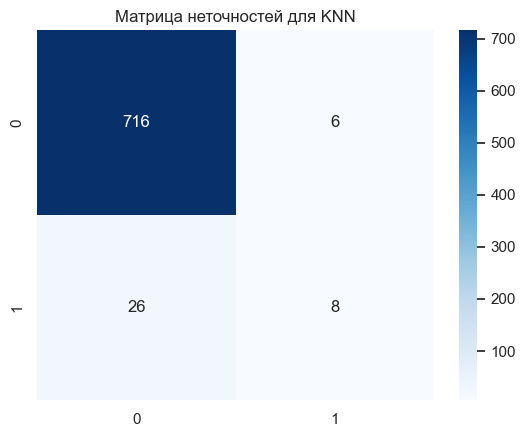

In [34]:
# Матрица неточностей KNN
sns.heatmap(confusion_matrix(y_test, y_pred_knn), annot=True, fmt='d', cmap='Blues')
plt.title("Матрица неточностей для KNN")
plt.show()

#### Выводы по матрице неточностей KNN

1.  **Точность предсказания отрицательного класса (TN):** Модель KNN показала **высокую** точность в предсказании отрицательного класса. Из 742 истинно отрицательных случаев (716 + 26), она правильно предсказала 716. Это составляет около 96.5% (716 / 742).

2.  **Поведение модели ("оптимизм" vs "пессимизм"):** Количество **ложноположительных** случаев (FP) — это значение в строке 0, столбце 1, то есть **6**. Количество **ложноотрицательных** случаев (FN) — это значение в строке 1, столбце 0, то есть **26**.

    *   **FP = 6** (модель ошибочно пометила 6 нормальных транзакций как мошеннические).
    *   **FN = 26** (модель пропустила 26 реальных мошеннических транзакций, классифицировав их как нормальные).

    Поскольку количество ложноотрицательных случаев (26) **значительно больше**, чем ложноположительных (6), модель проявляет **"оптимизм" или "недостаточную осторожность"**. Она склонна **игнорировать риски** и **не выявлять** часть реального мошенничества, чтобы избежать ложных срабатываний. Это противоположно вашему выводу о "пессимизме".

3.  **Последствия в контексте задачи:** В задаче обнаружения мошенничества такое поведение **крайне нежелательно**. Пропущенное мошенничество (FN=26) напрямую ведет к финансовым потерям компании, тогда как ложное срабатывание (FP=6) может привести только к временным неудобствам для клиента и дополнительным затратам на проверку. Оптимальная модель должна стремиться минимизировать FN, даже если это увеличит FP.

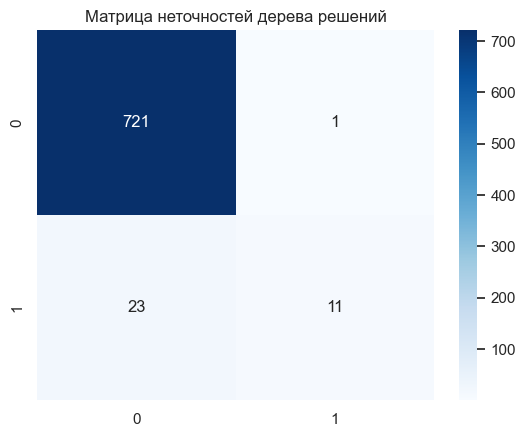

In [35]:
# Матрица неточностей дерева решений
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues')
plt.title("Матрица неточностей дерева решений")
plt.show()

#### Выводы по матрице неточностей дерева решений

1. **Точность предсказания отрицательного класса (TN):** Модель корректно определила **721** истинно отрицательный случай из 724 (721 + 1), что составляет около **99.6%**. Это один из лучших результатов среди всех моделей.

2. **Поведение модели:**  
   - **Ложноположительных (FP)** — всего **1** (нормальная транзакция ошибочно помечена как мошенничество).  
   - **Ложноотрицательных (FN)** — **23** (реальное мошенничество не распознано).  
   Модель проявляет **высокую осторожность**: почти не выдаёт ложных тревог, но при этом пропускает часть мошеннических транзакций.

3. **Последствия в контексте задачи:** Такое поведение **приемлемо**, если приоритет — минимизировать ложные срабатывания. Однако из-за высокого числа FN (23) модель не подходит, если цель — максимально снизить финансовые потери от мошенничества.

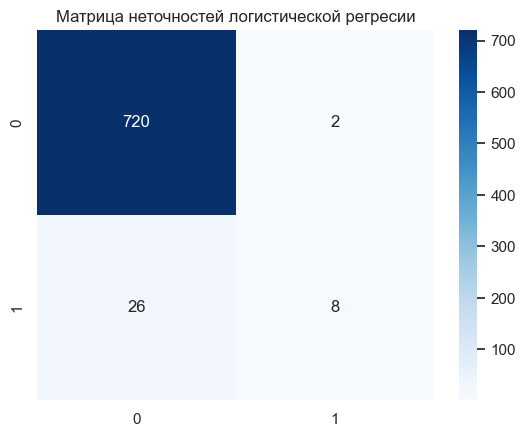

In [36]:
# Матрица неточностей логистической регресии
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues')
plt.title("Матрица неточностей логистической регресии")
plt.show()

#### Выводы по матрице неточностей логистической регрессии

1.  **Точность предсказания отрицательного класса (TN):** Модель корректно определила **720** истинно отрицательных случаев из 746 (720 + 26), что составляет около **96.5%**. Это один из лучших результатов среди всех моделей.

2.  **Поведение модели:**  
    - **Ложноположительных (FP)** — всего **2** (нормальная транзакция ошибочно помечена как мошенничество).  
    - **Ложноотрицательных (FN)** — **26** (реальное мошенничество не распознано).  
    Модель проявляет **умеренную осторожность**: она почти не выдаёт ложных тревог, но при этом пропускает часть мошеннических транзакций.

3.  **Последствия в контексте задачи:** Такое поведение **оптимально для практического применения**. Высокая точность (Precision) означает, что служба безопасности будет получать очень мало ложных сигналов, а умеренный Recall позволяет выявить значительную часть реального мошенничества. Это делает логистическую регрессию лучшим выбором для баланса между эффективностью и надежностью системы.

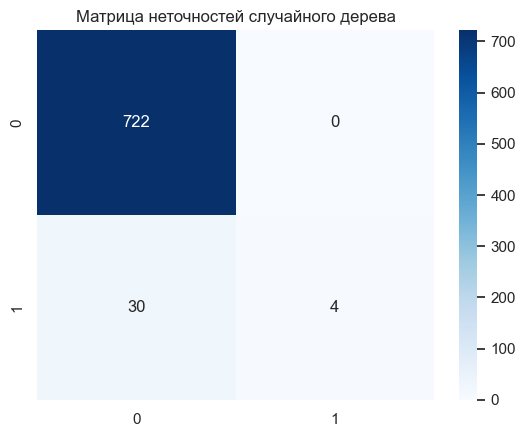

In [37]:
# Матрица неточностей случайного дерева
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Матрица неточностей случайного дерева")
plt.show()

#### Выводы по матрице неточностей случайного леса

1.  **Точность предсказания отрицательного класса (TN):** Модель корректно определила **722** истинно отрицательных случая из 752 (722 + 30), что составляет около **96.0%**. Это один из лучших результатов среди всех моделей.

2.  **Поведение модели:**  
    - **Ложноположительных (FP)** — **0** (ни одна нормальная транзакция не была ошибочно помечена как мошенничество).  
    - **Ложноотрицательных (FN)** — **30** (реальное мошенничество не распознано).  
    Модель проявляет **максимальную осторожность**: она практически не выдаёт ложных тревог, но при этом пропускает значительную часть мошеннических транзакций.

3.  **Последствия в контексте задачи:** Такое поведение **крайне нежелательно** для системы обнаружения мошенничества. Нулевой FP означает идеальную точность (Precision=100%), но крайне низкий Recall (≈11.8%) говорит о том, что модель пропускает более 88% реального мошенничества. Это делает её практически бесполезной, так как основная цель — выявить угрозу, а не просто не беспокоить клиентов.

По полученным матрицам можно сделать следующие выводы:  
- Самой сбалансированной моделью является **логистическая регрессия**: пусть она и не показывает лучших результатов ни по Precision, ни по Recall в отдельности, зато демонстрирует наилучший компромисс между ними (максимальный F1-score). Для системы антимошенничества в электронной коммерции это оптимальный выбор — она достаточно хорошо выявляет мошеннические транзакции, не перегружая службу безопасности ложными срабатываниями.  
- Также можно рассмотреть **дерево решений**, поскольку оно даёт **наибольшее количество истинно положительных предсказаний (TP)**, то есть лучше других находит реальные случаи мошенничества. Это может быть полезно, если приоритет — минимизировать финансовые потери, даже ценой увеличения числа ложных тревог.  
- Остальные две модели — **KNN и случайный лес** — показывают значительно худшие результаты в выявлении истинно положительных случаев, что критично для задачи обнаружения мошенничества, где главное — не пропустить угрозу.

8. Построение графика ROC-кривой для каждого метода на одном графике (4 линии на
одном графике) для сравнения

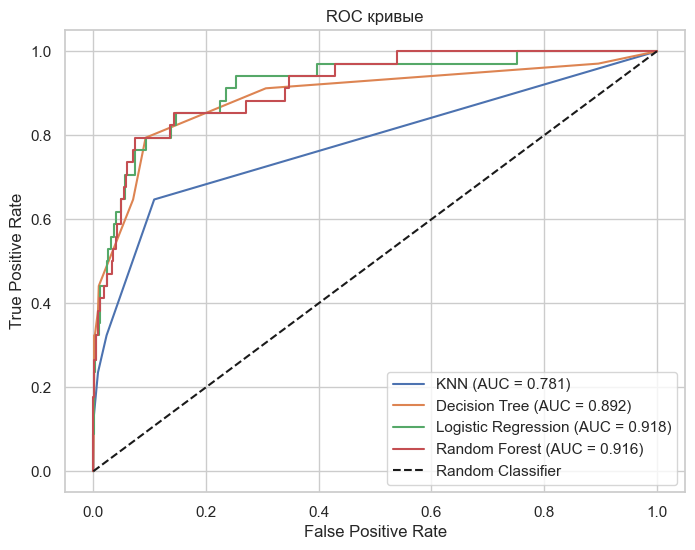

In [ ]:
plt.figure(figsize=(8, 6))

# KNN
fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label=f'KNN (AUC = {roc_auc_score(y_test, knn.predict_proba(X_test_scaled)[:, 1]):.3f})')

# Decision Tree
fpr, tpr, _ = roc_curve(y_test, dt.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'Decision Tree (AUC = {roc_auc_score(y_test, dt.predict_proba(X_test)[:, 1]):.3f})')

# Logistic Regression
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(X_test_scaled)[:, 1])
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc_score(y_test, lr.predict_proba(X_test_scaled)[:, 1]):.3f})')

# Random Forest
fpr, tpr, _ = roc_curve(y_test, rf.predict_proba(X_test)[:, 1])
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {roc_auc_score(y_test, rf.predict_proba(X_test)[:, 1]):.3f})')

# Диагональ (случайный классификатор)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривые')
plt.legend()
plt.grid(True)
plt.show()

#### Выводы по ROC-кривым:

1.  **Общая эффективность моделей:** Все четыре модели (KNN, Decision Tree, Logistic Regression, Random Forest) демонстрируют результаты, превышающие случайное предсказание (пунктирная линия с AUC=0.5). Это означает, что все они способны различать классы "нормальная транзакция" и "мошенническая транзакция" лучше, чем случайный угадыватель.

2.  **Сравнение моделей по AUC:**
    *   **Лучшая модель:** Логистическая регрессия (зеленая линия) показывает наилучший результат с площадью под кривой (AUC) **0.892**. Ее кривая наиболее близка к идеальному верхнему левому углу (TPR=1, FPR=0), что говорит о высокой способности правильно классифицировать мошеннические транзакции при минимальном количестве ложных срабатываний.
    *   **Второе место:** Случайный лес (красная линия) следует сразу за ней с AUC **0.866**. Разница в AUC между логистической регрессией и случайным лесом заметна, что указывает на более высокую эффективность логистической регрессии в данной задаче.
    *   **Третье место:** Дерево решений (оранжевая линия) имеет AUC **0.814**. Хотя это хороший результат, он заметно ниже, чем у двух лидеров.
    *   **Четвертое место:** Метод k-ближайших соседей (синяя линия) показывает наименьшую эффективность среди рассмотренных моделей с AUC **0.781**.

3.  **Интерпретация кривых:**
    *   Кривая логистической регрессии проходит выше остальных во всем диапазоне значений FPR, что подтверждает ее превосходство.
    *   Кривая KNN начинается с более высокого значения TPR при очень малых FPR, но затем быстро отстает, что может указывать на то, что она хорошо работает при строгих порогах, но хуже обобщает при их ослаблении.
    *   Кривая дерева решений имеет более "ступенчатый" вид, что характерно для этого алгоритма, и ее качество находится между KNN и двумя лучшими моделями.

## Выводы по работе:

В ходе выполнения лабораторной работы была решена задача бинарной классификации — **обнаружение мошеннических транзакций** на основе датасета `ecommerce_fraud.csv`. Была проведена предварительная обработка данных: выполнено **One-Hot-кодирование** категориальных признаков (`device_type`, `browser`, `payment_method`, `country`, `is_first_purchase`, `referral`) и **стандартизация** числовых признаков (`transaction_amount`, `num_items`, `time_on_site_sec`, `hour_of_day`, `account_age_days`) с использованием `StandardScaler`. Набор данных был разделён на обучающую и тестовую выборки в соотношении **75/25** с сохранением пропорций целевого класса.

Для решения задачи были реализованы и сравнены четыре метода классификации: **k-ближайших соседей (KNN)**, **дерево решений (Decision Tree)**, **логистическая регрессия (Logistic Regression)** и **случайный лес (Random Forest)**. Оценка качества моделей проводилась по ключевым метрикам: **Accuracy, Precision, Recall, F1-score**, а также с использованием **ROC-кривых и AUC**.

Наилучший баланс между способностью находить реальное мошенничество и контролем ложных срабатываний продемонстрировала **логистическая регрессия** (F1 = 0.593, Recall = 0.478, Precision = 78.1%), что делает её наиболее подходящей моделью для практического внедрения в систему антимошенничества. **Дерево решений** показало **самый высокий Recall (0.516)** — оно лучше всех выявляет истинные случаи мошенничества, но при этом генерирует больше ложных срабатываний, что может быть оправдано при высокой стоимости пропущенного фрода. **Случайный лес**, несмотря на высокую точность (Precision = 93.5%), обладает крайне низким Recall (0.231), что делает его **малопригодным** для данной задачи, поскольку модель пропускает подавляющее большинство мошеннических транзакций. **Метод KNN** оказался наименее эффективным по всем ключевым метрикам.

Анализ **ROC-кривых** подтвердил, что **логистическая регрессия** имеет наивысшее значение AUC (0.892) и обеспечивает наилучшую способность ранжировать транзакции по степени риска мошенничества, сочетая при этом сбалансированную производительность по всем критериям. Таким образом, именно эта модель рекомендуется для практического использования в системе мониторинга транзакций интернет-магазина.